In [30]:
from pymongo import MongoClient

from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob import Word
import nltk
import sklearn
import pandas as pd
import numpy as np
import re
import pprint
import seaborn as sns

%pylab inline

pd.options.display.max_columns = 150

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/miniconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [31]:
df = pd.read_pickle('2006_2017_votes_AND_cases').reset_index(drop=True)
df.head(10)

,case_term,lem_text,tb_subjectivity,tb_polarity,,Anthony M. Kennedy,Antonin Scalia,Clarence Thomas,David H. Souter,Elena Kagan,Elizabeth B. Prelogar,"John G. Roberts, Jr.",John Paul Stevens,Neil Gorsuch,Ruth Bader Ginsburg,"Samuel A. Alito, Jr.",Sonia Sotomayor,Stephen G. Breyer,other_speaker
0,United States v. Windsor 2012,We will hear argument this morning in Case 12-...,294.036681,64.647116,N/A,majority,minority,None,None,majority,None,minority,None,None,majority,minority,majority,majority,None
1,"Cyan, Inc. v. Beaver County Employees' Retirem...",We 'll hear argument first this morning in Cas...,175.909728,64.169899,N/A,majority,None,None,None,majority,None,majority,None,majority,majority,majority,majority,majority,None
2,Obergefell v. Hodges 2014,We 'll hear argument this morning in Case No ....,219.959198,63.824959,N/A,majority,minority,None,None,majority,None,minority,None,None,majority,minority,majority,majority,None
3,Environmental Protection Agency v. EME Homer C...,We will hear argument first this morning in Ca...,243.461358,63.376203,N/A,majority,minority,None,None,majority,None,majority,None,None,majority,None,majority,majority,None
4,Burwell v. Hobby Lobby Stores 2013,We 'll hear argument this morning in consolida...,246.326788,63.088403,N/A,majority,majority,None,None,minority,None,majority,None,None,minority,majority,minority,minority,None
5,"Masterpiece Cakeshop, Ltd. v. Colorado Civil R...",We 'll hear argument this morning in Case 16-1...,201.580901,62.086012,N/A,N/A,None,None,None,N/A,None,N/A,None,N/A,N/A,N/A,N/A,N/A,None
6,Shelby County v. Holder 2012,We 'll hear argument first this morning in Cas...,212.890237,59.637442,N/A,majority,majority,None,None,minority,None,majority,None,None,minority,majority,minority,minority,None
7,District of Columbia v. Heller 2007,"We will hear argument today in Case 07-290 , D...",267.603749,57.816510,N/A,majority,majority,None,minority,None,None,majority,minority,None,minority,majority,None,minority,None
8,"Entergy Corp. v. Riverkeeper, Inc. 2008",We will hear argument first today in Case 07-5...,199.742747,56.052606,N/A,majority,majority,None,minority,None,None,majority,minority,None,minority,majority,None,minority,None
9,Florida v. Powell 2009,We will hear argument next today in Case 08-11...,179.490225,55.265051,N/A,majority,majority,None,None,None,None,majority,minority,None,majority,majority,majority,minority,None


In [32]:
count_vectorizer = sklearn.feature_extraction.text.CountVectorizer(
        ngram_range=(1, 1),
        stop_words='english',
        token_pattern="\\b[a-z][a-z][a-z]+\\b",
        min_df=3,
        max_df=.6
    )
df_text = df['lem_text']

In [33]:
count_vectorizer.fit(df_text)
# Create the term-document matrix
counts = count_vectorizer.transform(df_text)
# this gives us a [num_documents, num_features] sparse matrix
print(f"Shape: {counts.shape}") 
#Shape: (827, 15081) 827 cases, 15,081 words


Shape: (827, 15081)


In [34]:
from sklearn import decomposition

In [35]:
lda = decomposition.LatentDirichletAllocation(
    n_components=30, 
    learning_method="online", 
    verbose=1, 
    max_iter=5, 
    n_jobs=-1
)

lda.fit(counts)

iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=30, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

In [36]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

print_top_words(lda,count_vectorizer.get_feature_names(),10)

Topic #0: candidate political election speech money amendment race contribution vote public
Topic #1: officer police amendment fourth search car warrant arrest stop probable
Topic #2: duty honest mcnally bribe kickback service voir dire disclose intangible
Topic #3: class agency limitation board review jurisdiction notice percent jurisdictional epa
Topic #4: plan immunity power sovereign remedy clause official policy military suit
Topic #5: virginia commerce dormant cost requester staters privileges archive access recoup
Topic #6: child tribe parent indian tribal father mother reservation jurisdiction marriage
Topic #7: memorial monument cross display symbol establishment injunction plaque commandments erected
Topic #8: witness testimony cocaine confrontation clause trial prosecutor crawford prosecution report
Topic #9: article child standing custody convention country marriage sex iii residence
Topic #10: information public service amendment officer enforcement force activity speech r

In [37]:
def dict_topic_words(model, feature_names, n_top_words):
    topic_dict={}
    for topic_idx, topic in enumerate(model.components_):
#         message = "Topic #%d: " % topic_idx
        message = ""
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
#         print(message)
        topic_dict[topic_idx]=message
#     print()
    return topic_dict


In [38]:
dict_topwords = dict_topic_words(lda,count_vectorizer.get_feature_names(),5)

In [39]:
# now let's transform our documents to topic-space
print(f"shape before transforming to topic space: {counts.shape}")

doc_topics = lda.transform(counts)

print(f"shape after transforming to topic space: {doc_topics.shape}") #200 lines, 30 topics

shape before transforming to topic space: (827, 15081)
shape after transforming to topic space: (827, 30)


In [40]:
case_list = list(df['case_term'])
doc_topics = pd.DataFrame(doc_topics)
doc_topics.index = case_list
# doc_topics.head()
# doc_topics.to_pickle("doc_topics")

In [41]:
### t-SNE:
from sklearn.manifold import TSNE
import sklearn.cluster as cluster

In [42]:
tsne = TSNE(n_components=2, random_state=0,metric='cosine')
#Project the data in 2D
X_2d = tsne.fit_transform(doc_topics)

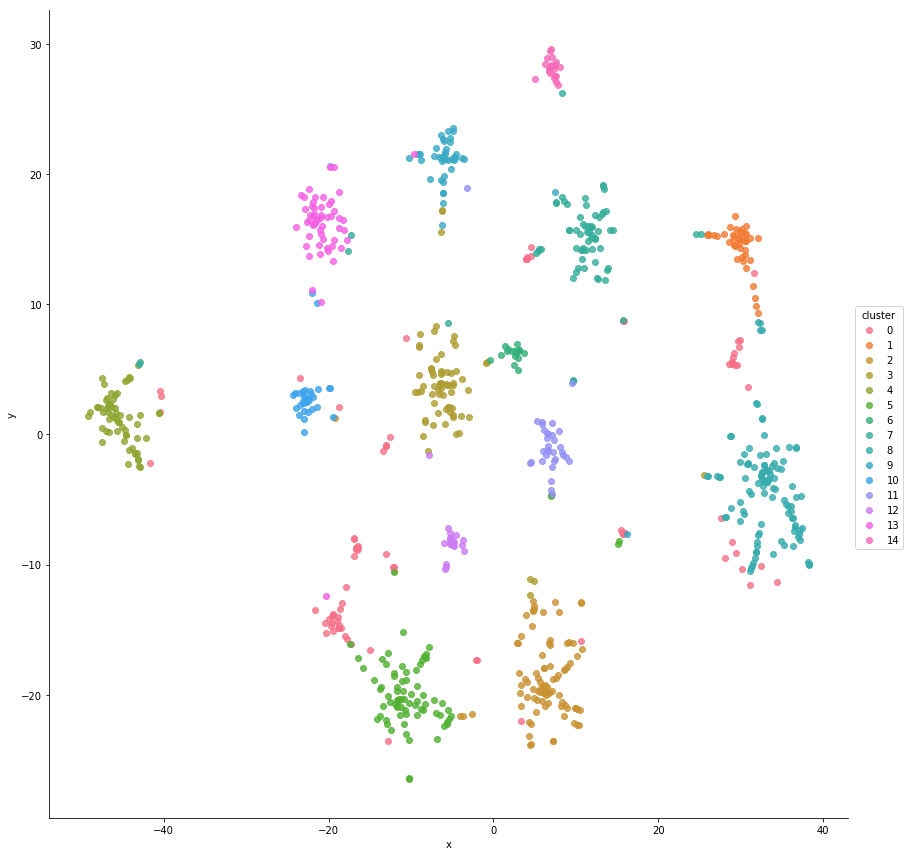

In [45]:
clustering = cluster.KMeans(n_clusters=15)
clusters = clustering.fit_predict(doc_topics)

data = pd.DataFrame()
data['x']=X_2d.T[0]
data['y']=X_2d.T[1]
data['cluster']=list(clusters)


doc_topics_cluster = doc_topics
doc_topics.columns = dict_topwords.values()


doc_topics_join = doc_topics_cluster.reset_index()['index'].reset_index()
data_casename = data.merge(doc_topics_join,left_index=True,right_index=True)
data_casename.drop('level_0',inplace=True,axis=1)
data_casename.head()

facet = sns.lmplot(data=data_casename, x='x', y='y', hue='cluster', 
                   fit_reg=False, legend=True
                   , legend_out=True, size=12, aspect=1)

In [46]:
data_casename.head()

,x,y,cluster,index
0,-7.238466,2.390844,3,United States v. Windsor 2012
1,5.927485,-20.493864,2,"Cyan, Inc. v. Beaver County Employees' Retirem..."
2,-13.039703,-9.166052,0,Obergefell v. Hodges 2014
3,6.340910,-19.999901,2,Environmental Protection Agency v. EME Homer C...
4,-4.952449,3.782256,3,Burwell v. Hobby Lobby Stores 2013


In [47]:
doc_topics.head()

,candidate political election speech money,officer police amendment fourth search,duty honest mcnally bribe kickback,class agency limitation board review,plan immunity power sovereign remedy,virginia commerce dormant cost requester,child tribe parent indian tribal,memorial monument cross display symbol,witness testimony cocaine confrontation clause,article child standing custody convention,information public service amendment officer,fda drug trust information duty,patent contract copyright infringement regulation,tax money fraud bank transaction,contract jurisdiction agreement price foreign,plaintiff fee damage property money,water compact montana user master,employee employer union discrimination pay,jury trial error conviction review,railroad carrier fcc tax property,dna gene isolated myriad body,california arbitration arbitrator trustee commissioner,jersey income delaware month wharf,land property water proximate river,rico puerto senate recess president,commission mark carolina north arm,charge notice sorna amendment percent,warning florida fbi miranda constitution,bankruptcy debt school debtor creditor,offense crime sentence sentencing guideline
United States v. Windsor 2012,0.013283,0.000009,0.000009,0.000009,0.736381,0.000009,0.073424,0.000009,0.001496,0.133910,0.000009,0.000009,0.005757,0.000009,0.000009,0.015072,0.000009,0.000009,0.015405,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.005086
"Cyan, Inc. v. Beaver County Employees' Retirement Fund 2017",0.000018,0.000018,0.000018,0.875633,0.040261,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.065785,0.017863,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018
Obergefell v. Hodges 2014,0.040751,0.000011,0.000011,0.006040,0.218468,0.000011,0.312360,0.000011,0.000011,0.350941,0.017269,0.000011,0.004046,0.000011,0.000011,0.000011,0.000011,0.013127,0.019171,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.017611
Environmental Protection Agency v. EME Homer City Generation 2013,0.035977,0.000011,0.000011,0.915278,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.026956,0.000011,0.000011,0.000011,0.006736,0.000011,0.000011,0.000011,0.000011,0.011476,0.000011,0.000011,0.003312,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011
Burwell v. Hobby Lobby Stores 2013,0.000011,0.000011,0.000011,0.000011,0.797623,0.000011,0.000011,0.000011,0.000011,0.000011,0.010652,0.004785,0.000011,0.036670,0.000011,0.000011,0.000011,0.150004,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011


In [48]:
# doc_topics.to_pickle("doc_topics_june3")
# data_casename.to_pickle("datacasename_june3_nocolors")

In [49]:
master_df = doc_topics.merge(right=data_casename,left_index=True,right_on='index')

In [50]:
master_df.sample()

,candidate political election speech money,officer police amendment fourth search,duty honest mcnally bribe kickback,class agency limitation board review,plan immunity power sovereign remedy,virginia commerce dormant cost requester,child tribe parent indian tribal,memorial monument cross display symbol,witness testimony cocaine confrontation clause,article child standing custody convention,information public service amendment officer,fda drug trust information duty,patent contract copyright infringement regulation,tax money fraud bank transaction,contract jurisdiction agreement price foreign,plaintiff fee damage property money,water compact montana user master,employee employer union discrimination pay,jury trial error conviction review,railroad carrier fcc tax property,dna gene isolated myriad body,california arbitration arbitrator trustee commissioner,jersey income delaware month wharf,land property water proximate river,rico puerto senate recess president,commission mark carolina north arm,charge notice sorna amendment percent,warning florida fbi miranda constitution,bankruptcy debt school debtor creditor,offense crime sentence sentencing guideline,x,y,cluster,index
797,0.000025,0.000025,0.000025,0.847621,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.022143,0.000025,0.104086,0.000025,0.000025,0.000025,0.002428,0.000025,0.000025,0.000025,0.000025,0.000025,0.023091,0.000025,0.000025,0.000025,0.000025,0.000025,5.333455,-20.417973,2,"Carlsbad Tech., Inc. v. HIF Bio, Inc. 2008"


In [51]:
master_df.to_pickle("master_df")

In [52]:
len(master_df)

827